In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.model_selection import train_test_split
import torchvision
import albumentations as A


## Class for Batching

In [4]:
class KeyPointsDataset2(torch.utils.data.Dataset):

  def __init__(self, df_x, df_y):
    self.df_x = df_x
    self.df_y = df_y

    self.transform = A.Compose([A.RandomRotate90(),
                                A.Blur(blur_limit = 3),
                                A.OpticalDistortion()])

  def __len__(self):
    return len(self.df_x)

  def __getitem__(self, idx):
    row_x = self.df_x.iloc[idx]      #row of batch for image pixels
    row_y = self.df_y.iloc[idx]      #row of batch for ground truth labels
    
    y = np.float32(row_y.to_numpy())

    x = np.float32(row_x.split( )) / 255     #split the string and convert into array of floats 
    x = np.reshape(x, (96,96))               #for RESNET/GoogleNet
    x = np.stack((x,x,x))                    #artificial 3 layers for RGB
    
    x = self.transform(image = x)['image']   #transform images
    x = np.reshape(x, (3,96,96))
    
    return x,y

##Creating Batches

In [6]:
def createBatch2(x_train, y_train, x_test, y_test):
  dataset_train = KeyPointsDataset2(x_train, y_train)
  dataset_test = KeyPointsDataset2(x_test, y_test)

  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 64, shuffle = True)
  dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 64, shuffle = True)

  return dataset_train, dataset_test, dataloader_train, dataloader_test

## Training GoogleNet

In [7]:
def trainGoogleNet(dataset_train, dataset_test, dataloader_train, dataloader_test):
  model = torchvision.models.googlenet(pretrained = True)
  model.fc = torch.nn.Linear(in_features = 1024, out_features = 30)

  # device = torch.device('cuda')
  # model = model.to(device)

  loss_fun = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

  num_epochs = 5
  N_train = len(dataset_train)
  N_test = len(dataset_test)

  train_losses = []
  test_losses = []


  for ep in range(num_epochs):

    model.train()
    train_loss = 0.0
    batch_idx = 0

    for X_batch, Y_batch in dataloader_train:

      # X_batch = X_batch.to(device)
      # Y_batch = Y_batch.to(device)

      N_batch = X_batch.shape[0]

      outputs = model(X_batch)
      loss_oneBatch = loss_fun(outputs, Y_batch)

      model.zero_grad()
      loss_oneBatch.backward()
      optimizer.step()


      train_loss += loss_oneBatch * N_batch

    model.eval()
    test_loss = 0.0
    for X_batch, Y_batch in dataloader_test:

      # X_batch = X_batch.to(device)
      # Y_batch = Y_batch.to(device)

      with torch.no_grad():
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        test_loss += loss_oneBatch * N_batch

    train_losses.append(train_loss / N_train)
    test_losses.append(test_loss / N_test)

    print('epoch: ', ep, ' train loss: ', (train_loss), ' test loss: ', (test_loss))


  return model, train_losses, test_losses

##Plot to Make Sure Model Works

In [8]:
def plot(train_losses, test_losses):
  plt.plot(train_losses, label = 'training loss')
  plt.plot(test_losses, label = 'test loss')
  plt.legend(loc = 'upper right')
  plt.title('Objective function value versus epoch')

##Plot Predictions vs Ground Truth on Random Train Image

In [9]:
#for GoogLeNet
def predRandomTrain2(model, df_train):
  # device = torch.device('cuda')

  rand_num = random.randint(0,7049)       #random image

  test_y = np.float32(df_train.iloc[rand_num, : 30].to_numpy())  
  img = df_train.iloc[rand_num,30]
  img = np.float32(img.split( )) / 255

  x = np.reshape(img, (96,96))               
  test_x = np.stack((x,x,x))
  test_x = np.reshape(test_x, (1,3,96,96))   

  test_x = torch.tensor(test_x)         #getting image ready for input
  # test_x = test_x.to(device) 
  
  pred = model(test_x)

  plt.imshow(np.reshape(img, (96,96)), cmap = 'gray')

  pred1 = pred.cpu().detach().numpy().flatten()

  for i in range(0, 30, 2):
    plt.plot(test_y[i], test_y[i + 1], marker='o', color="red")
    
    if (pred1[i] >= 0 and pred1[i + 1] >= 0):
      plt.plot(pred1[i], pred1[i + 1], marker='o', color="blue")
    else:
      plt.plot(0,0, marker='o', color="blue")

##Plot Prediction on a Test Image

In [34]:
# for GoogLeNet
def predTest2(model, df_test):
  # device = torch.device('cuda')

  rand_num = random.randint(0,1783)

  img = df_test.iloc[rand_num,1]
  img = np.float32(img.split( )) / 255

  x = np.reshape(img, (96,96))               
  test_x = np.stack((x,x,x))
  test_x = np.reshape(test_x, (1,3,96,96))

  test_x = torch.tensor(test_x)
  # test_x = test_x.to(device)

  pred = model(test_x)

  plt.imshow(np.reshape(img, (96,96)), cmap = 'gray')

  pred1 = pred.cpu().detach().numpy().flatten()
  for i in range(0, 30, 2):
    if (pred1[i] >= 0):
      plt.plot(pred1[i], pred1[i + 1], marker='o', color="blue")
    else:
      plt.plot(0,0, marker='o', color="blue")

##Main

In [14]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Math373Final/training.csv'

print('Reading CSV...')
df_train = pd.read_csv(train_path)

print('Filling Nulls...')
df_train = df_train.fillna(df_train.mean())       #this step takes me about 4.5minutes

X = df_train.iloc[:,30]
y = df_train.iloc[:, :30]

print('Splitting Train/Test Data...')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
dataset_train, dataset_test, dataloader_train, dataloader_test = createBatch2(x_train, y_train, x_test, y_test)

print('===========')
print('Training GoogleNet...')
model3, train_losses3, test_losses3 = trainGoogleNet(dataset_train, dataset_test, dataloader_train, dataloader_test)

print('===========')
print('Results:')
print('GoogleNet: Train - ', train_losses3[4], ' Test - ', test_losses3[4])

Reading CSV...
Filling Nulls...
Splitting Train/Test Data...
Training GoogleNet...
epoch:  0  train loss:  tensor(9814665., grad_fn=<AddBackward0>)  test loss:  tensor(1313453.3750)
epoch:  1  train loss:  tensor(2805110.2500, grad_fn=<AddBackward0>)  test loss:  tensor(337310.0625)
epoch:  2  train loss:  tensor(591696.3125, grad_fn=<AddBackward0>)  test loss:  tensor(52534.3320)
epoch:  3  train loss:  tensor(116517., grad_fn=<AddBackward0>)  test loss:  tensor(18341.6875)
epoch:  4  train loss:  tensor(55279.3203, grad_fn=<AddBackward0>)  test loss:  tensor(24813.4121)
Results:
GoogleNet: Train -  tensor(9.8030, grad_fn=<DivBackward0>)  Test -  tensor(17.5982)
CPU times: user 28min 56s, sys: 28.2 s, total: 29min 25s
Wall time: 29min 14s


### GoogLeNet Results

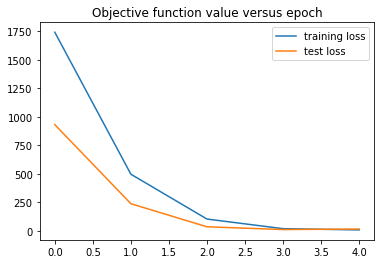

In [15]:
plot(train_losses3, test_losses3)

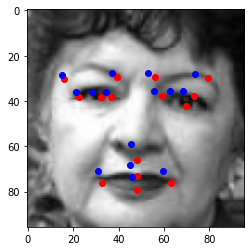

In [16]:
predRandomTrain2(model3, df_train)


torch.Size([1, 3, 96, 96])


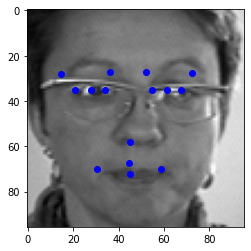

In [22]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Math373Final/test.csv'
df_test = pd.read_csv(test_path)
predTest2(model3, df_test)

##Kaggle

In [28]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Math373Final/test.csv'

df_test = pd.read_csv(test_path)

# device = torch.device('cuda')

final = pd.DataFrame(columns = ['Location'])


# predicting location values for all images and all facial features
for i in range(1783):
  img = df_test.iloc[i,1]
  img = np.float32(img.split( )) / 255     #split string and turned into float array

  x = np.reshape(img, (96,96))               #for GoogLeNet
  test_x = np.stack((x,x,x))  
  test_x = np.reshape(test_x, (1,3,96,96))
  test_x = torch.tensor(test_x)
  # test_x = test_x.to(device)

  pred = model3(test_x)   #pred is my predictions for rand_num image
  pred = pred.cpu().detach().numpy().flatten()


  df2 = pd.DataFrame(data=pred, columns=['Location'])
  final = final.append(df2, ignore_index=True)


Reading CSV...


In [29]:

sub_path = '/content/drive/MyDrive/Colab Notebooks/Math373Final/IdLookupTable.csv'
sub = pd.read_csv(sub_path)

In [35]:
from itertools import chain

feats = sub.loc[:29, ['FeatureName']]
feats = feats.values.tolist()
feats = list(chain.from_iterable(feats))

# assigning a number to each facial feature
d = {};
for j in range(len(feats)):
  d[feats[j]] = j + 1

# adding predicted values to the submission dataframe
for i in range(len(sub)):
  feat_name = sub.loc[i,'FeatureName']
  feat_num = d[feat_name]
  img_idx = sub.loc[i, 'ImageId']

  # converting the specified feature name to the row number in my predicted values
  pred_row = ((img_idx - 1) * 30) + feat_num - 1

  sub.loc[i,['Location']] = final.loc[pred_row, ['Location']]

sub = sub.loc[:, ['RowId', 'Location']]
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/Math373Final/submission.csv', index = False)
